### Task 3: Ensemble Learning

In [425]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns

#### CLASSIFICATION

In [426]:
df_class = pd.read_csv('WineQT.csv')
df_class = df_class.drop(columns=['Id'])

X_class = df_class.drop(columns=['quality'])  # Features
y_class = df_class['quality']  # Labels

# Handle missing values using SimpleImputer
imputer_class = SimpleImputer(strategy='most_frequent')
X_class = imputer_class.fit_transform(X_class)

# Normalize the data using MinMaxScaler
scaler_class = StandardScaler()
X_class = scaler_class.fit_transform(X_class)

label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(y_class)

# one hot encode y
y_class = np.eye(np.unique(y_class).shape[0])[y_class]

# Split the data into training, validation, and test sets
# 70% for training, 15% for validation, and 15% for testing
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_temp_class, y_temp_class, test_size=0.5, random_state=42)

#### MLP Classifier

In [427]:
class MlpClassifier:
  def __init__(
    self,
    inputLayerSize=13, 
    hiddenLayers=[4, 3], 
    outputLayerSize=1, 
    activation='relu', 
    learningRate=0.01,
    optimizer='mini-batch',
    batchSize=64, 
    iterations=100000
  ):
    self.inputLayerSize = inputLayerSize
    self.hiddenLayers = hiddenLayers
    self.outputLayerSize = outputLayerSize
    self.activation = activation
    self.learningRate = learningRate
    self.optimizer = optimizer
    self.batchSize = batchSize
    self.iterations = iterations
    
    self.weights = self.initializeWeights()
    
  def softmax(self, X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

  def initializeWeights(self):
    layerSizes = [self.inputLayerSize] + self.hiddenLayers + [self.outputLayerSize]
    weights = [np.random.randn(layerSizes[i - 1], layerSizes[i]) / np.sqrt(layerSizes[i - 1]) for i in range(1, len(layerSizes))]
    return weights

  def activate(self, z):
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-z))
    elif self.activation == 'tanh':
      return np.tanh(z)
    elif self.activation == 'relu':
      return np.maximum(0, z)

  def activateDerivative(self, z):
    if self.activation == 'sigmoid':
      return self.activate(z) * (1 - self.activate(z))
    elif self.activation == 'tanh':
      return 1 - np.tanh(z) ** 2
    elif self.activation == 'relu':
      return np.where(z <= 0, 0, 1)
    
  def costFunction(self, X, y):
    yHat = self.forward(X)[0][-1]
    epsilon = 1e-10
    yHat = np.maximum(yHat, epsilon)
    loss = -np.mean(y * np.log(yHat))
    return loss

  def forward(self, X):
    activations = [X]
    zValues = []
    layerInput = X
    for i in range(len(self.weights) - 1):
      z = np.dot(layerInput, self.weights[i])
      layerOutput = self.activate(z)
      activations.append(layerOutput)
      zValues.append(z)
      layerInput = layerOutput

    # Output layer with softmax activation
    output_layer = np.dot(layerInput, self.weights[-1])
    output_activation = self.softmax(output_layer)
    activations.append(output_activation)
    zValues.append(output_layer)

    return activations, zValues

  def backward(self, X, y, activations, zValues):
    m = X.shape[0]  # number of samples
    gradientsW = [np.zeros_like(weight) for weight in self.weights]

    # Compute gradients for the output layer with softmax activation and cross-entropy loss
    delta = activations[-1] - y
    gradientsW[-1] = np.dot(activations[-2].T, delta) / m

    # Backpropagate the error to compute gradients for hidden layers
    for i in range(len(self.weights) - 2, -1, -1):
      delta = np.dot(delta, self.weights[i + 1].T) * self.activateDerivative(zValues[i])
      gradientsW[i] = np.dot(activations[i].T, delta) / m

    return gradientsW

  def computeGradients(self, X, y):
    activations, zValues = self.forward(X)
    gradientsW = self.backward(X, y, activations, zValues)
    return gradientsW
  
  def getMiniBatches(self, X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []

    # Shuffle the data before creating mini-batches
    indices = np.random.permutation(num_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = (i + 1) * batch_size
      mini_batch_X = X_shuffled[start_idx:end_idx]
      mini_batch_y = y_shuffled[start_idx:end_idx]
      mini_batches.append((mini_batch_X, mini_batch_y))

    # If there are remaining samples, create one more mini-batch
    if num_samples % batch_size != 0:
      mini_batch_X = X_shuffled[num_batches * batch_size:]
      mini_batch_y = y_shuffled[num_batches * batch_size:]
      mini_batches.append((mini_batch_X, mini_batch_y))

    return mini_batches

  def updateWeights(self, gradientsW):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learningRate * gradientsW[i]
      
  def predict(self, X):
    return label_encoder.inverse_transform(np.argmax(self.forward(X)[0][-1], axis=1))
  
  def get_accuracy(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred == label_encoder.inverse_transform(np.argmax(y, axis=1)))

In [428]:
class Trainer_class(object):
  def __init__(self, N):
    # Make Local reference to network:
    self.N = N
    
  def sgd(self, X, y):
    k = 0
    for i in range(len(X)):
      x_sgd = X[i].reshape(1, -1)
      y_sgd = y[i].reshape(1, -1)
      grad = self.N.computeGradients(x_sgd, y_sgd)
      self.N.updateWeights(grad)
      k += 1
    return k

  def miniBatch(self, X, y, batch_size):
    k = 0
    mini_batches = self.N.getMiniBatches(X, y, batch_size=batch_size)
    for x_mini, y_mini in mini_batches:
      grad = self.N.computeGradients(x_mini, y_mini)
      self.N.updateWeights(grad)
      k += 1
    return k
  
  def batch(self, X, y):
    grad = self.N.computeGradients(X, y)
    self.N.updateWeights(grad)
    return 1
  
  def optimiser(self, X, y):
    if self.N.optimizer == 'sgd':
      return self.sgd(X, y)
    elif self.N.optimizer == 'mini-batch':
      return self.miniBatch(X, y, self.N.batchSize)
    elif self.N.optimizer == 'batch':
      return self.batch(X, y)
    
  def getMetrics(self, X, y_true):
    accuracy = self.N.get_accuracy(X, y_true)
    loss = self.N.costFunction(X, y_true)
    return loss, accuracy
  
  def predict(self, X):
    return self.N.predict(X)

  def train(self, X, y):
    #Make an internal variable for the callback function:
    self.X = X
    self.y = y

    #Make empty list to store costs:
    self.J = []

    loss = self.N.costFunction(X, y)
    k = 0
    maxiter = self.N.iterations

    while (loss > 1e-5) and (k < maxiter):
      k += self.optimiser(X, y)
      loss = self.N.costFunction(X, y)
      self.J.append(loss)

    # print("Operation terminated successfully.")
    # print("         Iterations: %d" % k)
    # print("         Final loss function: %f" % loss)

#### Decision Tree Classifier

In [439]:
class DTClassifier:
  def __init__(self, criterion='gini', max_depth='5', max_features='5'):
    self.model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)

  def train(self, X_train, y_train):
    self.model.fit(X_train, y_train)

  def predict(self, X_test):
    return label_encoder.inverse_transform(np.argmax(self.model.predict(X_test), axis=1))
  
  def predict_proba(self, X_test):
    return self.model.predict_proba(X_test)

  def evaluate(self, X_test, y_test):
    y_pred = self.predict(X_test)
    accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_test, axis=1)), y_pred)
    return accuracy

#### Logistic Regression

In [430]:
class MultinomialLogisticRegression:
  def __init__(self, learning_rate=0.01, epochs=1000):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.losses = []
    self.accuracies = []

  def _softmax(self, X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

  def _cross_entropy_loss(self, y_true, y_pred):
    N = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss

  def train(self, X_train, y_train):
    num_samples, num_features = X_train.shape
    num_classes = len(y_train[0])
    self.weights = np.random.rand(num_classes, num_features)

    for epoch in range(self.epochs):
      scores = np.dot(X_train, self.weights.T)
      probabilities = self._softmax(scores)

      # Compute cross-entropy loss on training set
      loss = self._cross_entropy_loss(y_train, probabilities)
      self.losses.append(loss)

      # Compute accuracy on training set
      y_pred_train = label_encoder.inverse_transform(np.argmax(probabilities, axis=1))
      accuracy_train = np.mean(y_pred_train == label_encoder.inverse_transform(np.argmax(y_train, axis = 1)))
      self.accuracies.append(accuracy_train)

      # Update weights using gradient descent
      error = probabilities - y_train
      gradient = np.dot(X_train.T, error) / num_samples
      self.weights -= self.learning_rate * gradient.T
  
    return self.losses, self.accuracies

  def predict_proba(self, X):
    scores = np.dot(X, self.weights.T)
    probabilities = self._softmax(scores)
    return probabilities
  
  def predict(self, X):
    return label_encoder.inverse_transform(np.argmax(self.predict_proba(X), axis=1))

  def evaluate_accuracy(self, X, y):
    y_pred = np.argmax(self.predict(X), axis = 1)
    accuracy = np.mean(y_pred == np.argmax(y, axis = 1))
    return accuracy

---

#### REGRESSION

In [431]:
HousingData = pd.read_csv('./HousingData.csv')

data_y = HousingData['MEDV']
data_x = HousingData.drop('MEDV', axis=1)

data_x = np.array(data_x)
data_y = np.array(data_y)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(data_x)
data_x = imputer.transform(data_x)

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = scaler.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(-1)
# partition the data into train, test and validation sets

Housing_x = data_x
Housing_y = data_y

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.25, random_state=42)


#### MLP Regressor

In [432]:
class MlpRegressor:
  def __init__(
    self,
    inputLayerSize=13, 
    hiddenLayers=[4, 3], 
    outputLayerSize=1, 
    activation='relu', 
    learningRate=0.01,
    optimizer='mini-batch',
    batchSize=64, 
    iterations=10000
  ):
    self.inputLayerSize = inputLayerSize
    self.hiddenLayers = hiddenLayers
    self.outputLayerSize = outputLayerSize
    self.activation = activation
    self.learningRate = learningRate
    self.optimizer = optimizer
    self.batchSize = batchSize
    self.iterations = iterations
    
    self.weights, self.biases = self.initializeWeights()

  def initializeWeights(self):
    layerSizes = [self.inputLayerSize] + self.hiddenLayers + [self.outputLayerSize]
    weights = [np.random.randn(layerSizes[i - 1], layerSizes[i]) * np.sqrt(2.0 / (layerSizes[i - 1] + layerSizes[i])) for i in range(1, len(layerSizes))]
    biases = [np.zeros((1, layerSizes[i])) for i in range(1, len(layerSizes))]
    return weights, biases

  def activate(self, z):
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-z))
    elif self.activation == 'tanh':
      return np.tanh(z)
    elif self.activation == 'relu':
      return np.maximum(0, z)

  def activateDerivative(self, z):
    if self.activation == 'sigmoid':
      return self.activate(z) * (1 - self.activate(z))
    elif self.activation == 'tanh':
      return 1 - np.tanh(z) ** 2
    elif self.activation == 'relu':
      return np.where(z <= 0, 0, 1)
    
  def costFunction(self, X, y):
    yHat = self.forward(X)[0][-1]
    J = 0.5 * sum((y - yHat) ** 2)
    return J[0]

  def forward(self, X):
    activations = [X]
    zValues = []
    layerInput = X
    for i in range(len(self.weights)):
      z = np.dot(layerInput, self.weights[i]) + self.biases[i]
      layerOutput = self.activate(z)
      activations.append(layerOutput)
      zValues.append(z)
      layerInput = layerOutput
    return activations, zValues

  def backward(self, X, y, activations, zValues):
    m = X.shape[0]
    gradientsW = [np.zeros_like(weight) for weight in self.weights]
    gradientsB = [np.zeros_like(bias) for bias in self.biases]

    delta = (activations[-1] - y) * self.activateDerivative(zValues[-1])
    gradientsW[-1] = np.dot(activations[-2].T, delta) / m
    gradientsB[-1] = np.sum(delta, axis=0) / m

    for i in range(len(self.weights) - 2, -1, -1):
      delta = np.dot(delta, self.weights[i + 1].T) * self.activateDerivative(zValues[i])
      gradientsW[i] = np.dot(activations[i].T, delta) / m
      gradientsB[i] = np.sum(delta, axis=0) / m

    return gradientsW, gradientsB

  def computeGradients(self, X, y):
    activations, zValues = self.forward(X)
    gradientsW = self.backward(X, y, activations, zValues)
    return gradientsW
  
  def getMiniBatches(self, X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []

    # Shuffle the data before creating mini-batches
    indices = np.random.permutation(num_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = (i + 1) * batch_size
      mini_batch_X = X_shuffled[start_idx:end_idx]
      mini_batch_y = y_shuffled[start_idx:end_idx]
      mini_batches.append((mini_batch_X, mini_batch_y))

    # If there are remaining samples, create one more mini-batch
    if num_samples % batch_size != 0:
      mini_batch_X = X_shuffled[num_batches * batch_size:]
      mini_batch_y = y_shuffled[num_batches * batch_size:]
      mini_batches.append((mini_batch_X, mini_batch_y))

    return mini_batches
  
  def updateWeights(self, gradientsW, gradientsB):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learningRate * gradientsW[i]
      self.biases[i] -= self.learningRate * gradientsB[i]
      
  def getMetrics(self, yHat, y):
    # compute mse, rmse, and rsquared
    mse = np.mean((y - yHat) ** 2)
    rmse = np.sqrt(mse)
    ssr = np.sum((yHat - y) ** 2)
    sst = np.sum((y - y.mean()) ** 2)
    rsquared = 1 - (ssr / sst)
    return mse, rmse, rsquared

In [433]:
class Trainer_reg(object):
  def __init__(self, N):
    # Make Local reference to network:
    self.N = N
    
  def sgd(self, X, y):
    k = 0
    for i in range(len(X)):
      x_sgd = X[i].reshape(1, -1)
      y_sgd = y[i].reshape(1, -1)
      gradw, gradb = self.N.computeGradients(x_sgd, y_sgd)
      self.N.updateWeights(gradw, gradb)
      k += 1
    return k

  def miniBatch(self, X, y, batch_size):
    k = 0
    mini_batches = self.N.getMiniBatches(X, y, batch_size=batch_size)
    for x_mini, y_mini in mini_batches:
      gradw, gradb = self.N.computeGradients(x_mini, y_mini)
      self.N.updateWeights(gradw, gradb)
      k += 1
    return k
  
  def batch(self, X, y):
    gradw, gradb = self.N.computeGradients(X, y)
    self.N.updateWeights(gradw, gradb)
    return 1
  
  def optimiser(self, X, y):
    if self.N.optimizer == 'sgd':
      return self.sgd(X, y)
    elif self.N.optimizer == 'mini-batch':
      return self.miniBatch(X, y, self.N.batchSize)
    elif self.N.optimizer == 'batch':
      return self.batch(X, y)
    
  def getMetrics(self, X, y):
    yHat = self.predict(X)
    mse, rmse, rsquared = self.N.getMetrics(yHat, y)
    return mse, rmse, rsquared
  
  def evaluate(self, X, y):
    mse, rmse, rsquared = self.getMetrics(X, y)
    return rsquared
  
  def predict(self, X):
    return self.N.forward(X)[0][-1]

  def train(self, X, y):
    self.X = X
    self.y = y

    self.J = []

    loss = self.N.costFunction(X, y)
    k = 0
    maxiter = self.N.iterations

    while (loss > 1e-5) and (k < maxiter):
      k += self.optimiser(X, y)
      loss = self.N.costFunction(X, y)
      self.J.append(loss)

#### Decision Tree Regressor

In [434]:
class DTRegressor:
  def __init__(self, criterion='gini', max_depth='5', max_features='5'):
    self.model = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth, max_features=max_features)

  def train(self, X_train, y_train):
    self.model.fit(X_train, y_train)

  def predict(self, X_test):
    return self.model.predict(X_test)
  
  def rsquared(self, X_test, y_test):
    y_pred = self.predict(X_test)
    ssr = np.sum((y_pred - y_test) ** 2)
    sst = np.sum((y_test - y_test.mean()) ** 2)
    rsquared = 1 - (ssr / sst)
    return rsquared

  def evaluate(self, X_test, y_test):
    rsq = self.rsquared(X_test, y_test)
    return rsq

#### Linear Regressor

In [438]:
class LinearRegression:
  def __init__(self, learning_rate=0.001, epochs=1000):
    self.learning_rate = learning_rate
    self.n_iterations = epochs

  def train(self, X, y):
    self.n_samples, self.n_features = X.shape
    self.weights = np.zeros(self.n_features)
    self.bias = 0
    self.X = X
    self.y = y

    for _ in range(self.n_iterations):
      y_predicted = self.predict(X)
      dw = (1/self.n_samples) * np.dot(X.T, (y_predicted - y))
      db = (1/self.n_samples) * np.sum(y_predicted - y)
      self.weights -= self.learning_rate * dw
      self.bias -= self.learning_rate * db

  def predict(self, X):
    return np.dot(X, self.weights) + self.bias
  
  def evaluate(self, X, y):
    y_pred = self.predict(X)
    return 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))

#### best metrics for the models

In [436]:
best_metrics = {}

best_metrics['decision_tree_classifier'] = {
}

best_metrics['mlp_classifier'] = {
  'epochs': 10000,
  'learning_rate': 0.01,
  'hidden_layers': [9, 7],
  'activation': 'relu',
  'optimizer': 'batch',
  'batch_size': 64
}

best_metrics['logistic_regression'] = {
  'epochs': 1000,
  'learning_rate': 0.1
}


best_metrics['mlp_regressor'] = {
  'epochs': 20000,
  'learning_rate': 0.0005,
  'hidden_layers': [6, 2],
  'activation': 'relu',
  'optimizer': 'mini-batch',
  'batch_size': 64
}

best_metrics['linear_regression'] = {
}

best_metrics['decision_tree_regressor'] = {
}

#### For best metrics of decision tree classifier

In [440]:
best_accuracy = 0

criterion = ['gini', 'entropy']
features = [3,5,7,9,11]
max_depth = [3,5,10,20,30]

for c in criterion:
  for md in max_depth:
    for f in features:
      dt_classifier = DTClassifier(criterion=c, max_depth=md, max_features=f)
      dt_classifier.train(X_train_class, y_train_class)
      accuracy = dt_classifier.evaluate(X_val_class, y_val_class)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_criterion = c
        best_max_depth = md
        best_features = f
  
print(f'Best accuracy: {best_accuracy}')
print(f'Best criterion: {best_criterion}')
print(f'Best max depth: {best_max_depth}')
print(f'Best features: {best_features}')

best_metrics['decision_tree_classifier']['criterion'] = best_criterion
best_metrics['decision_tree_classifier']['max_depth'] = best_max_depth
best_metrics['decision_tree_classifier']['max_features'] = best_features

Best accuracy: 0.6432748538011696
Best criterion: gini
Best max depth: 20
Best features: 5


#### For best metrics of decision tree regressor

In [446]:
criterion = ['friedman_mse', 'absolute_error', 'squared_error']
features = [3,5,7,9,11]
max_depth = [3,5,10,20,30]

best_rsq = 0

for c in criterion:
  for md in max_depth:
    for f in features:
      dt_reg = DTRegressor(criterion=c, max_depth=md, max_features=f)
      dt_reg.train(X_train_reg, y_train_reg)
      rsq = dt_reg.evaluate(X_val_reg, y_val_reg)
      if rsq > best_rsq:
        best_rsq = rsq
        best_criterion = c
        best_max_depth = md
        best_features = f

print(f'Best rsquared: {best_rsq}')
print(f'Best criterion: {best_criterion}')
print(f'Best max depth: {best_max_depth}')
print(f'Best features: {best_features}')

best_metrics['decision_tree_regressor']['criterion'] = best_criterion
best_metrics['decision_tree_regressor']['max_depth'] = best_max_depth
best_metrics['decision_tree_regressor']['max_features'] = best_features

Best rsquared: 0.8198240773654443
Best criterion: squared_error
Best max depth: 10
Best features: 3


#### For best metrics of Linear Regressor

In [447]:
epochs = [100, 1000, 10000]
lrs = [0.01, 0.001]

best_rsq = 0

for e in epochs:
  for lr in lrs:
    linear_regression = LinearRegression(epochs=e, learning_rate=lr)
    linear_regression.train(X_train_reg, y_train_reg)
    rsq = linear_regression.evaluate(X_val_reg, y_val_reg)
    if rsq > best_rsq:
      best_rsq = rsq
      best_epochs = e
      best_lr = lr
      
print(f'Best rsquared: {best_rsq}')
print(f'Best epochs: {best_epochs}')
print(f'Best learning rate: {best_lr}')

best_metrics['linear_regression']['epochs'] = best_epochs
best_metrics['linear_regression']['learning_rate'] = best_lr

Best rsquared: 0.6853885604829472
Best epochs: 10000
Best learning rate: 0.01


#### Best models Classification

In [448]:
best_mlp_classifier = MlpClassifier(
  inputLayerSize=X_train_class.shape[1],
  iterations=best_metrics['mlp_classifier']['epochs'],
  learningRate=best_metrics['mlp_classifier']['learning_rate'],
  hiddenLayers=best_metrics['mlp_classifier']['hidden_layers'],
  outputLayerSize=y_train_class.shape[1],
  activation=best_metrics['mlp_classifier']['activation'],
  optimizer=best_metrics['mlp_classifier']['optimizer'],
  batchSize=best_metrics['mlp_classifier']['batch_size']
)

best_mlp_classifier_trainer = Trainer_class(best_mlp_classifier)

best_dt_classifier = DTClassifier(
  criterion=best_metrics['decision_tree_classifier']['criterion'],
  max_depth=best_metrics['decision_tree_classifier']['max_depth'],
  max_features=best_metrics['decision_tree_classifier']['max_features']
)

best_logistic_classifer = MultinomialLogisticRegression(
  epochs=best_metrics['logistic_regression']['epochs'],
  learning_rate=best_metrics['logistic_regression']['learning_rate']
)

#### Best models Regression

In [449]:
best_mlp_regressor = MlpRegressor(
  inputLayerSize=X_train_reg.shape[1],
  iterations=best_metrics['mlp_regressor']['epochs'],
  learningRate=best_metrics['mlp_regressor']['learning_rate'],
  hiddenLayers=best_metrics['mlp_regressor']['hidden_layers'],
  outputLayerSize=1,
  activation=best_metrics['mlp_regressor']['activation'],
  optimizer=best_metrics['mlp_regressor']['optimizer'],
  batchSize=best_metrics['mlp_regressor']['batch_size']
)

best_mlp_regressor_trainer = Trainer_reg(best_mlp_regressor)

best_dtReg = DTRegressor(
  criterion=best_metrics['decision_tree_regressor']['criterion'],
  max_depth=best_metrics['decision_tree_regressor']['max_depth'],
  max_features=best_metrics['decision_tree_regressor']['max_features']
)

best_linear_regression = LinearRegression(
  learning_rate=best_metrics['linear_regression']['learning_rate'],
  epochs=best_metrics['linear_regression']['epochs']
)

### Task 3.2: Bagging Ensemble

In [450]:
def bagging_ensemble(base_estimator, num_estimators, fr_samples, bootstrap, voting_mechanism, X_train, y_train, X_val, y_val, type):

  predictions = []

  for _ in range(num_estimators):
    if(bootstrap):
      sample_indices = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*fr_samples), replace=True)
    else:
      sample_indices = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*fr_samples), replace=False)

    X_train_sample = X_train[sample_indices]
    y_train_sample = y_train[sample_indices]
    
    base_estimator.train(X_train_sample, y_train_sample)
    # print(_)
    predictions.append(base_estimator.predict(X_val))

  predictions = np.array(predictions)

  weights = np.ones(num_estimators)

  if(voting_mechanism == 'hard'):
    weights = np.ones(num_estimators)
  elif(voting_mechanism == 'soft'):
    if(type == 'classification'):
      for i in range(num_estimators):
        probs = base_estimator.predict_proba(X_val)
        conf = np.max(probs, axis=1)
        weights[i] = np.mean(conf)
    elif(type == 'regression'):
      # take the confidence as the performance on the test set
      for i in range(num_estimators):
        weights[i] = base_estimator.evaluate(X_val, y_val)

  if(type == 'classification'):
    # normalize the weights
    weights = weights/np.sum(weights)
    predictions = np.average(predictions, axis=0, weights=weights)
    predictions = np.round(predictions)
  elif(type == 'regression'):
    weights = weights/np.sum(weights)
    predictions = np.average(predictions, axis=0, weights=weights)

  return predictions

In [451]:
def plot_heatmap(data, x_labels, y_labels, title):
  sns.heatmap(data, annot=True, fmt=".3f", xticklabels=x_labels, yticklabels=y_labels, cmap='YlGnBu')
  plt.title(title)
  plt.xlabel('Fraction of Samples')
  plt.ylabel('Number of Estimators')
  plt.show()

In [452]:
n_estimators = [1,2,5,10]
sample_sizes = [0.15, 0.25, 0.5, 0.75, 1]

### Bagging for classification

#### MLP Classifier

In [477]:
accuracy_scores = []
for n in n_estimators:
  accuracy_scores.append([])
  for s in sample_sizes:
    bagging_ensemble(best_mlp_classifier_trainer, n, s, True, 'hard', X_train_class, y_train_class, X_val_class, y_val_class, 'classification')
    accuracy = best_mlp_classifier_trainer.getMetrics(X_val_class, y_val_class)[1]
    accuracy_scores[-1].append(accuracy)

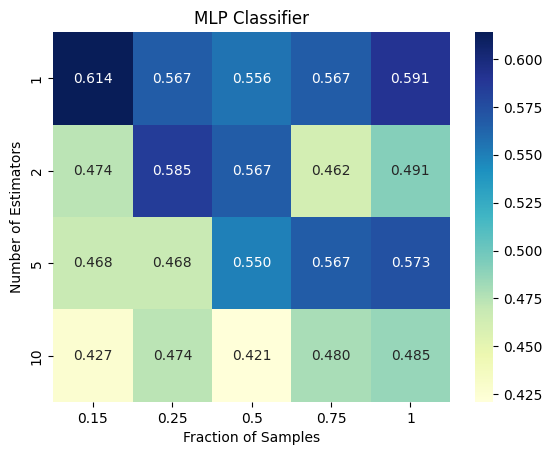

In [454]:
plot_heatmap(np.array(accuracy_scores), sample_sizes, n_estimators, 'MLP Classifier')

In [486]:
max_mlp_classifier_accuracy = np.max(accuracy_scores)

#### Decision Tree Classifier

In [487]:
accuracy_scores = []
for n in n_estimators:
  accuracy_scores.append([])
  for s in sample_sizes:
    y_pred = bagging_ensemble(best_dt_classifier, n, s, True, 'hard', X_train_class, y_train_class, X_val_class, y_val_class, 'classification')
    accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_val_class, axis=1)), y_pred)
    accuracy_scores[-1].append(accuracy)

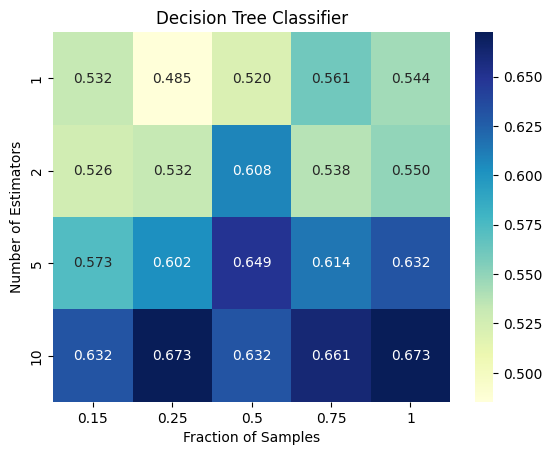

In [488]:
plot_heatmap(np.array(accuracy_scores), sample_sizes, n_estimators, 'Decision Tree Classifier')

In [489]:
max_dtclassifier_accuracy = np.max(accuracy_scores)

#### Logistic Regression

In [490]:
accuracy_scores = []
for n in n_estimators:
  accuracy_scores.append([])
  for s in sample_sizes:
    y_pred = bagging_ensemble(best_logistic_classifer, n, s, True, 'hard', X_train_class, y_train_class, X_val_class, y_val_class, 'classification')
    accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_val_class, axis=1)), y_pred)
    accuracy_scores[-1].append(accuracy)

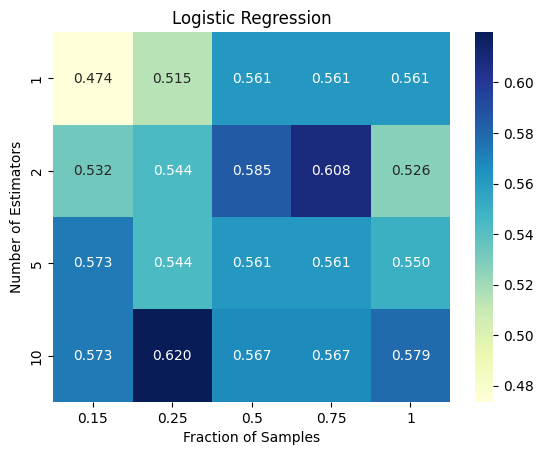

In [491]:
plot_heatmap(np.array(accuracy_scores), sample_sizes, n_estimators, 'Logistic Regression')

In [492]:
max_logistic_accuracy = np.max(accuracy_scores)

---

### Bagging for regression

#### MLP Regressor

In [493]:
r2_scores = []
for n in n_estimators:
  r2_scores.append([])
  for s in sample_sizes:
    bagging_ensemble(best_mlp_regressor_trainer, n, s, True, 'soft', X_train_reg, np.array(y_train_reg).reshape(-1,1), X_val_reg, np.array(y_val_reg).reshape(-1,1), 'regression')
    r2 = best_mlp_regressor_trainer.getMetrics(X_val_reg, np.array(y_val_reg).reshape(-1,1))[2]
    print(r2)
    r2_scores[-1].append(r2)

0.3254737385443198
0.3631216226910772
0.33078259354673
0.35042130338199884
0.38117241907855604
0.38819186366181413
0.40107514298714686
0.3488683024932915
0.35961814196684605
0.3615924208279234
0.35976908203360103
0.37352804897866665
0.3476355501286643
0.33127824751198454
0.3585186229337115
0.279010990890291
0.3363375148719645
0.3749389596684163
0.3785143660575796
0.369319638840369


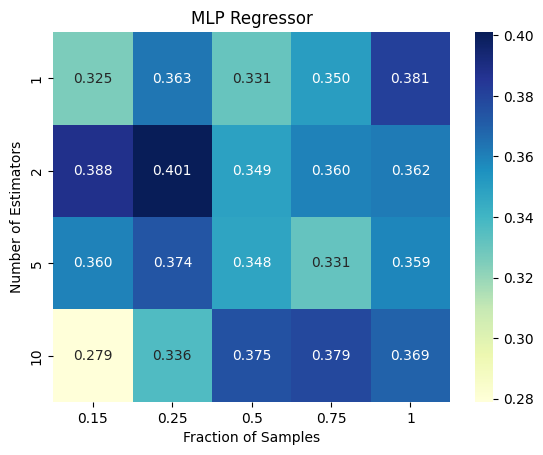

In [494]:
plot_heatmap(np.array(r2_scores), sample_sizes, n_estimators, 'MLP Regressor')

In [495]:
max_mlp_regressor_r2 = np.max(r2_scores)

#### Linear Regressor

In [496]:
r2_scores = []
for n in n_estimators:
  r2_scores.append([])
  for s in sample_sizes:
    y_pred = bagging_ensemble(best_linear_regression, n, s, True, 'soft', X_train_reg, np.array(y_train_reg), X_val_reg, np.array(y_val_reg), 'regression')
    r2 = best_linear_regression.evaluate(X_val_reg, np.array(y_val_reg))
    print(r2)
    r2_scores[-1].append(r2)

0.49300763922479085
0.6166729387921772
0.6841566504350816
0.6892622466959828
0.6604562733931507
0.559323727694546
0.15495911284653185
0.6554799522561445
0.6832055037552017
0.6581080707534737
0.4848167078020331
0.6706824915465621
0.6353488769815809
0.6625673371917068
0.6360327497948342
0.4971344687470497
0.5685261776813811
0.6272282992682653
0.6497527892881061
0.6574670420655185


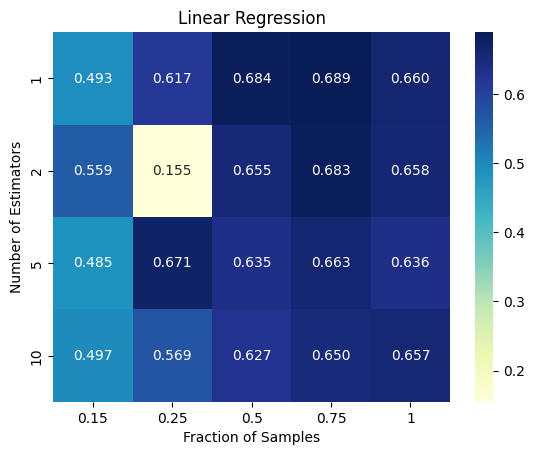

In [497]:
plot_heatmap(np.array(r2_scores), sample_sizes, n_estimators, 'Linear Regression')

In [498]:
max_linear_regressor_r2 = np.max(r2_scores)

#### Decision Tree Regressor

In [499]:
r2_scores = []
for n in n_estimators:
  r2_scores.append([])
  for s in sample_sizes:
    y_pred = bagging_ensemble(best_dtReg, n, s, True, 'soft', X_train_reg, np.array(y_train_reg), X_val_reg, np.array(y_val_reg), 'regression')
    r2 = best_dtReg.evaluate(X_val_reg, np.array(y_val_reg))
    print(r2)
    r2_scores[-1].append(r2)

0.45368891650510257
0.01949014492157619
0.4922329308152936
0.6462557188190605
0.5515815005264372
0.19452146293451533
0.46547394981036194
0.4533179246256832
0.5789483340591304
0.37883434668074123
0.26644831071437214
0.3283228026202569
0.45998763935442
0.42099654112391705
0.3945994450199336
0.27907782094406763


0.4203034073418448
0.4978226903909895
0.5195468977127247
0.5976353279146134


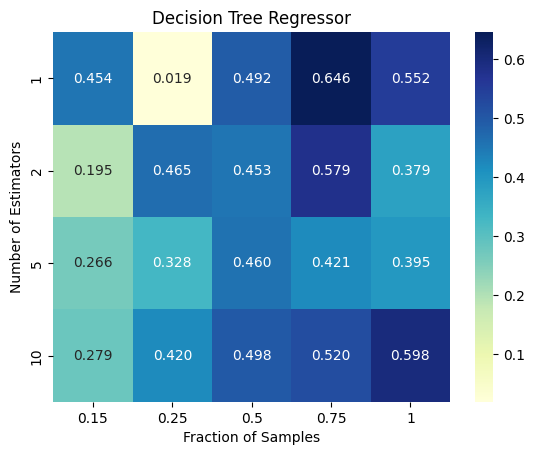

In [500]:
plot_heatmap(np.array(r2_scores), sample_sizes, n_estimators, 'Decision Tree Regressor')

In [501]:
max_dt_regressor_r2 = np.max(r2_scores)

#### Plotting the histograms

#### Classification

In [544]:
best_model_classifiers_accuracies = []

temp_moodel = MlpClassifier(
  inputLayerSize=X_train_class.shape[1],
  iterations=best_metrics['mlp_classifier']['epochs'],
  learningRate=best_metrics['mlp_classifier']['learning_rate'],
  hiddenLayers=best_metrics['mlp_classifier']['hidden_layers'],
  outputLayerSize=y_train_class.shape[1],
  activation=best_metrics['mlp_classifier']['activation'],
  optimizer=best_metrics['mlp_classifier']['optimizer'],
  batchSize=best_metrics['mlp_classifier']['batch_size']
)

temp_trainer = Trainer_class(temp_moodel)
temp_trainer.train(X_train_class, y_train_class)
best_model_classifiers_accuracies.append(temp_trainer.getMetrics(X_test_class, y_test_class)[1])

In [545]:
temp_model = DTClassifier(
  criterion=best_metrics['decision_tree_classifier']['criterion'],
  max_depth=best_metrics['decision_tree_classifier']['max_depth'],
  max_features=best_metrics['decision_tree_classifier']['max_features']
)

temp_model.train(X_train_class, y_train_class)
best_model_classifiers_accuracies.append(temp_model.evaluate(X_test_class, y_test_class))

In [546]:
temp_moodel = MultinomialLogisticRegression(
  epochs=best_metrics['logistic_regression']['epochs'],
  learning_rate=best_metrics['logistic_regression']['learning_rate']
)

temp_moodel.train(X_train_class, y_train_class)
best_model_classifiers_accuracies.append(accuracy_score(temp_model.predict(X_test_class), label_encoder.inverse_transform(np.argmax(y_test_class, axis=1))))

In [547]:
bagging_accuracies = []
bagging_accuracies.append(max_mlp_classifier_accuracy)
bagging_accuracies.append(max_dtclassifier_accuracy)
bagging_accuracies.append(max_logistic_accuracy)

#### Histogram for classification

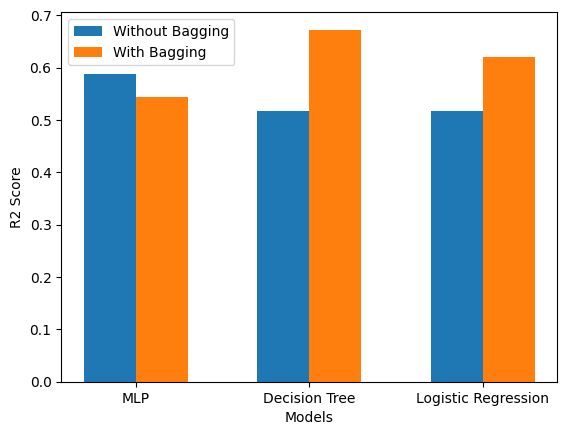

In [514]:
models = ['MLP', 'Decision Tree', 'Logistic Regression']

x = np.arange(len(models))
plt.bar(x-0.15, best_model_classifiers_accuracies, width=0.3, label='Without Bagging')
plt.bar(x+0.15, bagging_accuracies, width=0.3, label='With Bagging')
plt.xticks(x, models)
plt.legend()
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.show()

#### Regression

In [540]:
bagging_r2s = [max_mlp_regressor_r2, max_dt_regressor_r2, max_linear_regressor_r2]
best_model_regressors_r2 = []

temp_moodel = MlpRegressor(
  inputLayerSize=X_train_reg.shape[1],
  iterations=best_metrics['mlp_regressor']['epochs'],
  learningRate=best_metrics['mlp_regressor']['learning_rate'],
  hiddenLayers=best_metrics['mlp_regressor']['hidden_layers'],
  outputLayerSize=1,
  activation=best_metrics['mlp_regressor']['activation'],
  optimizer=best_metrics['mlp_regressor']['optimizer'],
  batchSize=best_metrics['mlp_regressor']['batch_size']
)

temp_trainer = Trainer_reg(temp_moodel)
temp_trainer.train(X_train_reg, np.array(y_train_reg).reshape(-1,1))
best_model_regressors_r2.append(temp_trainer.getMetrics(X_val_reg, np.array(y_val_reg).reshape(-1,1))[2])

In [541]:
temp_model = DTRegressor(
  criterion=best_metrics['decision_tree_regressor']['criterion'],
  max_depth=best_metrics['decision_tree_regressor']['max_depth'],
  max_features=best_metrics['decision_tree_regressor']['max_features']
)

temp_model.train(X_train_reg, np.array(y_train_reg))
best_model_regressors_r2.append(temp_model.evaluate(X_val_reg, np.array(y_val_reg)))

In [542]:
temp_model = LinearRegression(
  learning_rate=best_metrics['linear_regression']['learning_rate'],
  epochs=best_metrics['linear_regression']['epochs']
)

temp_model.train(X_train_reg, np.array(y_train_reg))
best_model_regressors_r2.append(temp_model.evaluate(X_val_reg, np.array(y_val_reg)))

#### Histogram for regression

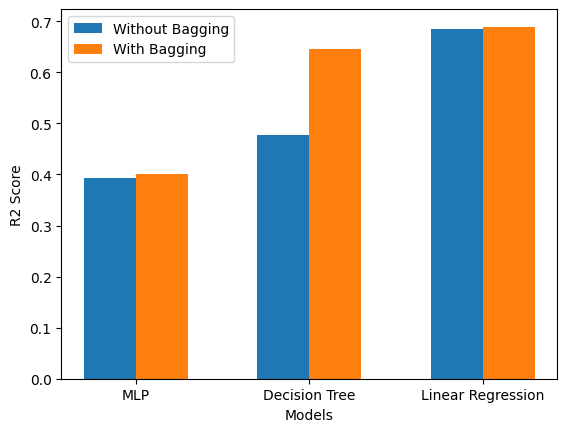

In [543]:
models = ['MLP', 'Decision Tree', 'Linear Regression']

plt.bar(x-0.15, best_model_regressors_r2, width=0.3, label='Without Bagging')
plt.bar(x+0.15, bagging_r2s, width=0.3, label='With Bagging')
plt.xticks(x, models)
plt.legend()
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.show()

### Task 3.3: Stacking and Blending

#### Stacking

In [471]:
def stacking_ensemble(base_models, meta_model, X_train, y_train, X_val, y_val, X_test, stacking_method):
  base_model_predictions = []

  for model in base_models:
    try:
      model.train(X_train, y_train)
    except:
      model.train(X_train, np.array(y_train).reshape(-1,1))

    if stacking_method == 'stacking':
      pred = model.predict(X_train)
    elif stacking_method == 'blending':
      pred = model.predict(X_val)

    pred = np.array(pred).reshape(-1)
    base_model_predictions.append(pred)
    # print(pred)
  
  base_model_predictions = np.array(base_model_predictions).T
  # print(base_model_predictions)

  if stacking_method == 'stacking':
    meta_model.train(base_model_predictions, y_train)
    test_predictions = []

    for model in base_models:
      pred = model.predict(X_test)
      pred = np.array(pred).reshape(-1)
      test_predictions.append(pred)

    test_predictions = np.array(test_predictions).T
    # print(test_predictions)
    predictions = meta_model.predict(test_predictions)
    # print(predictions)

  elif stacking_method == 'blending':
    meta_model.train(base_model_predictions, y_val)
    test_predictions = []

    for model in base_models:
      pred = model.predict(X_test)
      pred = np.array(pred).reshape(-1)
      test_predictions.append(pred)

    test_predictions = np.array(test_predictions).T
    predictions = meta_model.predict(test_predictions)

  return predictions

#### Classification

In [470]:
base_models_classification = [best_mlp_classifier_trainer, best_dt_classifier, best_logistic_classifer]

best_dt_classifier_stack = DTClassifier(
  criterion=best_metrics['decision_tree_classifier']['criterion'],
  max_depth=best_metrics['decision_tree_classifier']['max_depth'],
  max_features=best_metrics['decision_tree_classifier']['max_features']
)

best_logistic_classifer_stack = MultinomialLogisticRegression(
  epochs=best_metrics['logistic_regression']['epochs'],
  learning_rate=best_metrics['logistic_regression']['learning_rate']
)

meta_models_classification = [best_dt_classifier_stack, best_logistic_classifer_stack]

In [472]:
for m in meta_models_classification:
  y_pred = stacking_ensemble(base_models_classification, m, X_train_class, y_train_class, X_val_class, y_val_class, X_test_class, 'stacking')
  accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_test_class,axis=1)), y_pred)
  print(accuracy)

0.5174418604651163
0.4186046511627907


#### Regression

In [475]:
best_linear_regression_stack_base = LinearRegression(
  learning_rate=best_metrics['linear_regression']['learning_rate'],
  epochs=best_metrics['linear_regression']['epochs']
)

best_mlp_reg_base = MlpRegressor(
  inputLayerSize=X_train_reg.shape[1],
  iterations=best_metrics['mlp_regressor']['epochs'],
  learningRate=best_metrics['mlp_regressor']['learning_rate'],
  hiddenLayers=best_metrics['mlp_regressor']['hidden_layers'],
  outputLayerSize=1,
  activation=best_metrics['mlp_regressor']['activation'],
  optimizer=best_metrics['mlp_regressor']['optimizer'],
  batchSize=best_metrics['mlp_regressor']['batch_size']
)
best_mlp_regressor_trainer_stack_base = Trainer_reg(best_mlp_reg_base)

best_dtReg_stack_base = DTRegressor(
  criterion=best_metrics['decision_tree_regressor']['criterion'],
  max_depth=best_metrics['decision_tree_regressor']['max_depth'],
  max_features=best_metrics['decision_tree_regressor']['max_features']
)

base_models_regression = [best_mlp_regressor_trainer_stack_base, best_linear_regression_stack_base, best_dtReg_stack_base]

best_dtReg_stack = DTRegressor(
  criterion=best_metrics['decision_tree_regressor']['criterion'],
  max_depth=best_metrics['decision_tree_regressor']['max_depth'],
  max_features=best_metrics['decision_tree_regressor']['max_features']
)

best_linear_regression_stack = LinearRegression(
  learning_rate=best_metrics['linear_regression']['learning_rate'],
  epochs=best_metrics['linear_regression']['epochs']
)

meta_models_regression = [best_dtReg_stack, best_linear_regression_stack]

In [476]:
for m in meta_models_regression:
  y_pred = stacking_ensemble(base_models_regression, m, X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, 'stacking')
  ssr = np.sum((y_pred - y_test_reg) ** 2) 
  sst = np.sum((y_test_reg - np.mean(y_test_reg)) ** 2)
  r2 = 1 - (ssr / sst)
  print(r2)

0.38604961983103014
0.7095949677570949
